# Selection of lakes - EFAS
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 12-11-2024<br>

**Introduction:**<br>
This notebook selects lakes to be added in EFASv6. [HydroLakes](https://www.hydrosheds.org/products/hydrolakes) is used as the only dataset source, as it is the most recent and exhaustive. The code does the following:

* Imports lakes and reservoirs already in EFAS.
* Imports the HydroLake dataset and keeps only the lake or controlled lakes within the EFAS domain than comply with these rules:
    * Lake volume of at least 10 hm3.
    * Lake area of at least 5 km².
    * Catchment area of at least 50 km².
    * Degree of regulation of at least 30 days.
* For the resulting selection of lakes, it defines the priority to be added to EFAS (1 for highest priority, 4 for lowest). It sorts the lakes in decreasing order of volume and selects the minimum number of lakes needed to reach a target percentage of the total lake storage in Europe.

| % total volume | priority |
| :------------- | :------- |
| 80             | 1        |
| 85             | 2        |
| 90             | 3        |
| 95             | 4        |
| -              | -9999    |

* Finally, it removes from the selection those lakes already included in EFAS5 either as lakes or reservoirs, and reservoirs selected to be added in EFAS6.

**To do:**

* [x] Find lakes in D2 selection that are not in my selection and viceversa
* [ ] Check why lakes in EFAS are not in HydroLakes
* [x] Remove from selection those lakes already in EFASv5
* [ ] I haven't used at all the GLWD dataset. The reservoirs in EFASv5 were mostly source from GLWD level 1 or 2.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import glob
import pandas as pd
import dask.dataframe as dd
import dask_geopandas as dgpd
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopandas as gpd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from tqdm.notebook import tqdm
from shapely.geometry import Point
from pathlib import Path

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from lisfloodreservoirs.utils.utils import filter_domain, filter_reservoirs, find_connections, remove_duplicates
from lisfloodreservoirs.utils.plots import plot_reservoir_map

In [4]:
# def scientific_format(num):
#     if num == 0:
#         return '0'
#     else:
#         exponent = int(np.log10(abs(num)))
#         prefix = num / 10**(exponent - 1)
#         suffix = '⁰¹²³⁴⁵⁶⁷⁸⁹'[exponent]  # Unicode superscript digits for 0 to 9
#         return f"{prefix:.0f}{suffix}"

## Configuration

In [21]:
# paths
PATH_EFAS = Path('Z:/nahaUsers/casadje/EFASv5')
PATH_DATASETS = Path('Z:/nahaUsers/casadje/datasets/')
PATH_HYDROLAKES = PATH_DATASETS / 'lakes' / 'HydroLAKES'
PATH_OUT = PATH_DATASETS / 'lakes' / 'EFASv6' #Path('../results/reservoirs/selection/EFAS/')
PATH_OUT.mkdir(parents=True, exist_ok=True)

# minimum storage capacity included in EFAS
MIN_VOLUME = 10 # hm³
MIN_AREA = 5 # km²
MIN_CATCHMENT = 50 # km²
MIN_DOR = 30 # days

## EFAS

### Static map

In [6]:
# load the upstream area map
uparea = rxr.open_rasterio(PATH_EFAS / 'static_maps' / 'upArea_European_01min.nc').squeeze(dim='band')
uparea = uparea.where(uparea != -999999, np.nan)

# load the domain
domain = rxr.open_rasterio(PATH_EFAS / 'static_maps' / 'domain_area_European_01min.nc').squeeze(dim='band')
lon_min, lat_min, lon_max, lat_max = np.round(domain.rio.bounds(), 6)
efas_cellsize = np.mean(np.diff(domain.x)) # degrees

### Reservoirs

In [7]:
# reservoirs in EFASv5
efas_res = gpd.read_file(PATH_OUT.parent.parent / 'reservoirs' / 'EFASv6' / 'EFAS5' / 'efas5_reservoirs.shp')
efas_res.set_index('ResID', drop=True, inplace=True)
efas_res = efas_res[efas_res.GRAND_ID.notnull()]
efas_res.GRAND_ID = efas_res.GRAND_ID.astype(int)

In [8]:
# reservoirs to be added in EFASv6
grand_to_add = gpd.read_file(PATH_OUT.parent.parent / 'reservoirs' / 'EFASv6' / 'GRanD' / 'grand_to_add.shp')
grand_to_add.set_index('GRAND_ID', drop=True, inplace=True)

### Lakes

#### Raster

In [9]:
efas_raster = xr.open_dataset(PATH_EFAS / 'static_maps' / 'lakes_European_01min.nc')['lakes']

# remove rows/columns with all NaN
aux = efas_raster.where(~efas_raster.isnull(), drop=True)
# extract an array of reservoir ID
ids = np.unique(aux)
ids = ids[~np.isnan(ids)]

# extract coordinates of each reservoir
efas_coords = pd.DataFrame(index=ids, columns=['lon', 'lat'])
efas_area = pd.Series(index=ids, dtype=float)
for ID in tqdm(efas_coords.index):
    cell = efas_raster.where(efas_raster == ID, drop=True)
    lon, lat = cell.lon.item(), cell.lat.item()
    efas_coords.loc[int(ID)] = lon, lat
    efas_area.loc[int(ID)] = uparea.sel(x=lon, y=lat, method='nearest', tolerance=1e-4).item()
efas_coords = efas_coords.round(6)

# convert area to km2
efas_area *= 1e-6

del aux

  0%|          | 0/204 [00:00<?, ?it/s]

#### Metadata

In [10]:
# load efas metadata
efas = pd.read_csv(PATH_EFAS / 'tables' / 'EFAS_HRES_lakes_metadata.csv')
efas.LakID = efas.LakID.astype(int)
efas.set_index('LakID', inplace=True)
efas = gpd.GeoDataFrame(efas,
                        geometry=[Point(xy) for xy in zip(efas.LisfloodX, efas.LisfloodY)],
                        crs=4326)

# add catchment area (km2)
efas['catch_area'] = efas_area

# add attributes from the tables used in LISFLOOD
prefix = 'lake'
for file in (PATH_EFAS / 'tables').glob(f'{prefix}*.txt'):
    var = file.stem.removeprefix(prefix)
    try:
        df = pd.read_csv(file, sep=' ', header=None)
        df.dropna(axis=1, how='all', inplace=True)
        df.columns = ['LakID', var]
        df.set_index('LakID', inplace=True, drop=True)
        efas[var] = df
    except:
        print(file)
        continue

# convert area to km2
efas['area'] /= 1e6 

efas.rename(columns={col: col.upper() for col in efas.columns if col != 'geometry'},
            inplace=True)

#### Comparison

In [11]:
print('no. lakes in the metadata:\t{0}'.format(efas.shape[0]))
print('no. lakes in the raster:\t{0}'.format(efas_coords.shape[0]))
print('lakes missing in the metadata:\t{0}'.format(efas_coords.index.difference(efas.index).to_list()))
print('lakes missing in the raster:\t{0}'.format(efas.index.difference(efas_coords.index).to_list()))

no. lakes in the metadata:	204
no. lakes in the raster:	204
lakes missing in the metadata:	[]
lakes missing in the raster:	[]


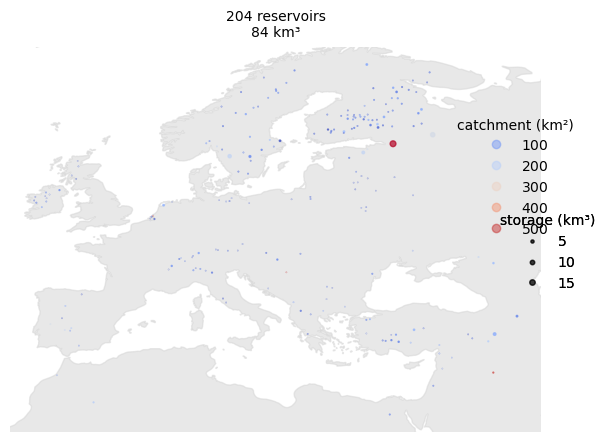

In [14]:
# plot lake map
plot_reservoir_map(
    efas.geometry,
    efas.AREA_KM2,
    efas.CATCH_AREA,
    # save=PATH_OUT / 'efasv5_lakes.jpg'
)

>***Figure 1**. Lakes included in GloFAS. The size of the dots represents the lake area.*

In [13]:
# # map of GloFAS lakes
# fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
# ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
# # glofas.plot(markersize=glofas.A * .5e-2, alpha=.5, ax=ax)#, cmap='coolwarm', c=grand_dams.DOR_PC
# scatter = ax.scatter(glofas.geometry.x, glofas.geometry.y, s=glofas.A / 1000, alpha=.5)
# ax.text(.5, 1.125, 'GloFAS lakes', horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes, fontsize=12)
# text = '{0} lakes\n{1:.0f}·10³ km²'.format(glofas.shape[0], glofas.A.sum() / 1000)
# ax.text(.5, 1.02, text, horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
# ax.axis('off');

# # legend
# legend2 = ax.legend(*scatter.legend_elements(prop='sizes', num=4, alpha=.5), title='area (10³ km²)', bbox_to_anchor=[1.025, .3, .1, .4], frameon=False)
# ax.add_artist(legend2);

# # save
# plt.savefig(f'{path_out}glofas_lakes.jpg', dpi=300, bbox_inches='tight')

# print('no. lakes in GloFAS:\t\t{0}\t({1} with A > {2} km²)'.format(glofas.shape[0], (glofas.A >= MIN_CATCHMENT).sum(), MIN_CATCHMENT))
# print('total lake area in GloFAS:\t{0:.0f} km²'.format(glofas.A.sum()))

In [14]:
# efas.to_file(PATH_OUT / 'efasv5_lakes.shp')

Area of the smallest lake:	1.600 km²


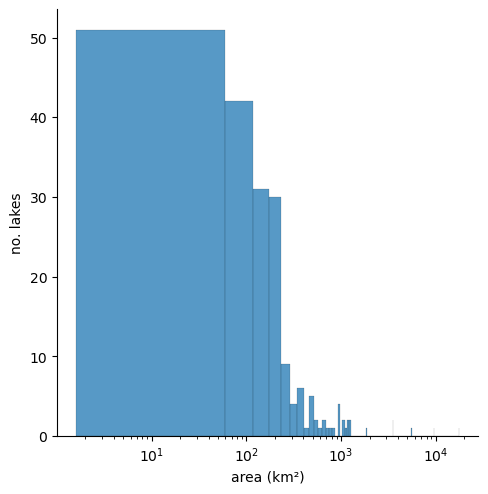

In [15]:
# distribution of the lake area
sns.displot(efas.AREA_KM2)
plt.xlabel('area (km²)')
plt.ylabel('no. lakes');
plt.xscale('log');

print('Area of the smallest lake:\t{0:.3f} km²'.format(efas.AREA_KM2.min()))

>***Figure 2**. Lake surface area distribution in GloFAS.*

As explained in [Zajac et al. (2017)](https://www.sciencedirect.com/science/article/pii/S0022169417301671), only lakes with a minimum area of 50 km² are included in GloFAS.

### Selection rules

In [16]:
mask_hylak = efas.Hylak_id != -9999
print('{0:>5} lakes ({1:.0f} km3) have a HydroLakes ID'.format(
    mask_hylak.sum(),
    efas[mask_hylak].HYLAK_VOL.sum() * 1e-3
))

mask_catchment = efas.AREA_KM2 >= MIN_CATCHMENT
print('{0:>5} lakes ({1:.0f} km3) have a catchment larger than {2} km2'.format(
    mask_catchment.sum(),
    efas[mask_catchment].HYLAK_VOL.sum() * 1e-3,
    MIN_CATCHMENT
))

mask_volume = efas.HYLAK_VOL >= MIN_VOLUME
print('{0:>5} lakes ({1:.0f} km3) have a volume larger than {2} hm3'.format(
    mask_volume.sum(),
    efas[mask_volume].HYLAK_VOL.sum() * 1e-3,
    MIN_VOLUME
))

mask_residence = efas.HYLAK_DOR >= MIN_DOR
print('{0:>5} lakes ({1:.0f} km3) have a residence time larger than {2} days'.format(
    mask_residence.sum(),
    efas[mask_residence].HYLAK_VOL.sum() * 1e-3,
    MIN_DOR
))

mask_area = efas.AREA_KM2 >= MIN_AREA
print('{0:>5} lakes ({1:.0f} km3) have a surface area larger than {2} km2'.format(
    mask_area.sum(),
    efas[mask_area].HYLAK_VOL.sum() * 1e-3,
    MIN_AREA
))

mask_cvr = mask_volume & mask_residence & mask_catchment
print('{0:>5} lakes ({1:.0f} km3) comply with the catchment, volume and residence time rules'.format(
    mask_cvr.sum(),
    efas[mask_cvr].HYLAK_VOL.sum() * 1e-3,
))

mask_cvra = mask_cvr & mask_area
print('{0:>5} lakes ({1:.0f} km3) comply with the catchment, volume, residence time and area rules'.format(
    mask_cvra.sum(),
    efas[mask_cvra].HYLAK_VOL.sum() * 1e-3,
))

AttributeError: 'GeoDataFrame' object has no attribute 'Hylak_id'

## HydroLakes

HydroLAKES ([Messager et al., 2016](https://www.nature.com/articles/ncomms13603)) contains more than 1.4 million points of water bodies (both lakes, controlled lakes and reservoirs). 

Interesting fields:

* `Lake_type` indicates the type of water body:
    * 1: lake.
    * 2: reservoir.
    * 3: lake control
* `Lake_area`: surface area in km².
* `Vol_total`: total lake/reservoir volume in hm³.
* `Vol_res`: reported reservoir volume, or storage volume of added lake regulation (hm³)
* `Vol_src`: source of volume data:
    * 1: ‘Vol_total’ is the reported total lake volume from literature
    * 2: ‘Vol_total’ is the reported total reservoir volume from GRanD or literature
    * 3: ‘Vol_total’ is the estimated total lake volume using the geostatistical modeling approach by Messager et al. (2016)
* `Depth_avg`: average depth in m.
* `Dis_avg`: average long-term discharge (m3).
* `Res_time`: average residence time in days.
* `Wshd_area`: area of the lake's watershed in km2.
* `Pour_long` and `Pour_lat` are the coordinates of the pour point in decimal degrees.
* `dis_m3_pyr`: annual average natural discharge.

### Import

#### Outlets

In [ ]:
# # columns to be used from HydroATLAS
# cols = ['Hylak_id', 'Lake_name', 'Country', 'Continent', 'Poly_src', 'Lake_type', 'Grand_id', 'Lake_area',
#         'Shore_len', 'Shore_dev', 'Vol_total', 'Vol_res', 'Vol_src', 'Depth_avg', 'Dis_avg',
#         'Res_time', 'Elevation', 'Slope_100', 'Wshd_area', 'Pour_long', 'Pour_lat', 'dis_m3_pyr']

In [22]:
# load HydroLAKES
hydrolakes= dgpd.read_file(
    PATH_HYDROLAKES / 'LakeATLAS_v10_shp' / 'LakeATLAS_v10_pnt_east.shp',
    # columns=cols,
    npartitions=10
).set_index('Hylak_id', drop=True)

# keep only lakes (1) and lagoons (3)
hydrolakes = hydrolakes[hydrolakes.Lake_type.isin([1, 3])].compute()

# filter by extent
mask_extent = (lon_min <= hydrolakes.geometry.x) &  (hydrolakes.geometry.x <= lon_max) & (lat_min <= hydrolakes.geometry.y) & (hydrolakes.geometry.y <= lat_max)
hydrolakes = hydrolakes[mask_extent]

# keep points inside the domain
pbar = tqdm(hydrolakes.iterrows(), total=hydrolakes.shape[0])
mask_domain = [
    ID for ID, point in pbar
    if domain.sel(x=point.geometry.x, y=point.geometry.y, method='nearest').item() == 1
]
hydrolakes = hydrolakes.loc[mask_domain]

  0%|          | 0/106553 [00:00<?, ?it/s]

In [23]:
# total lake volume in the domain
total_lake_volume = hydrolakes.Vol_total.sum()
print('total lake volume = {0:.0f} km3'.format(total_lake_volume * 1e-3))

total lake volume = 4140 km3


In [24]:
hylak_pnt_shp = PATH_OUT / 'hydrolakes_pnt.shp'
if hylak_pnt_shp.is_file():
    # import hydrolake points within the domain
    E1 = gpd.read_file(hylak_shp).set_index('Hylak_id', drop=True)
    print('{0:>5} lakes ({1:.0f} km3) comply with the catchment, volume, residence time and area rules'.format(
        E1.shape[0],
        E1.Vol_total.sum() * 1e-3,
    ))

else:

    mask_catchment = hydrolakes.Wshd_area >= MIN_CATCHMENT
    print('{0:>5} lakes ({1:.0f} km3) have a catchment larger than {2} km2'.format(
        mask_catchment.sum(),
        hydrolakes[mask_catchment].Vol_total.sum() * 1e-3,
        MIN_CATCHMENT
    ))
    
    mask_volume = hydrolakes.Vol_total >= MIN_VOLUME
    print('{0:>5} lakes ({1:.0f} km3) have a volume larger than {2} hm3'.format(
        mask_volume.sum(),
        hydrolakes[mask_volume].Vol_total.sum() * 1e-3,
        MIN_VOLUME
    ))

    mask_residence = hydrolakes.Res_time >= MIN_DOR
    print('{0:>5} lakes ({1:.0f} km3) have a residence time larger than {2} days'.format(
        mask_residence.sum(),
        hydrolakes[mask_residence].Vol_total.sum() * 1e-3,
        MIN_DOR
    ))

    mask_area = hydrolakes.Lake_area >= MIN_AREA
    print('{0:>5} lakes ({1:.0f} km3) have a surface area larger than {2} km2'.format(
        mask_area.sum(),
        hydrolakes[mask_area].Vol_total.sum() * 1e-3,
        MIN_AREA
    ))

    mask_cvr = mask_volume & mask_residence & mask_catchment
    print('{0:>5} lakes ({1:.0f} km3) comply with the catchment, volume and residence time rules'.format(
        mask_cvr.sum(),
        hydrolakes[mask_cvr].Vol_total.sum() * 1e-3,
    ))

    mask_cvra = mask_cvr & mask_area
    print('{0:>5} lakes ({1:.0f} km3) comply with the catchment, volume, residence time and area rules'.format(
        mask_cvra.sum(),
        hydrolakes[mask_cvra].Vol_total.sum() * 1e-3,
    ))
    
    # selection of lakes and accumulated volume
    E1 = hydrolakes[mask_cvra].copy()

    # export selection of points
    E1.to_file(PATH_OUT / 'hydrolakes_pnt.shp')

NameError: name 'hylak_shp' is not defined

#### Polygons

In [ ]:
hylak_pol_shp = PATH_OUT / 'hydrolakes_pol.shp'
if hylak_pnt_shp.is_file() is False:

    # load HydroLakes polygons
    hydrolakes_pol = dgpd.read_file(
        PATH_HYDROLAKES / 'LakeATLAS_v10_shp' / 'LakeATLAS_v10_pol_east.shp',
        # columns=cols,
        npartitions=20
    )
    
    # apply selection of points
    mask = hydrolakes_pol.Hylak_id.isin(hydrolakes.index.tolist())
    hydrolakes_pol = hydrolakes_pol[mask].compute()

    # export selection of polygons
    hydrolakes_pol.to_file(hylak_pol_shp)

#### D2 selection

In [ ]:
# selection of lakes whose polygon overlays the LISFLOOD river network
sel1 = gpd.read_file(PATH_OUT / 'pistoal' / 'EFASselectedLakepoints.shp')
sel1.set_index('Hylak_id', drop=True, inplace=True)

# selection of lakes whose outlet overlays the LISFLOOD river network
sel2 = gpd.read_file(PATH_OUT / 'pistoal' / 'EFASselectedOutlets.shp')
sel2.set_index('HyLak_Id', drop=True, inplace=True)
sel2.index.name = sel1.index.name
sel2.index = sel2.index.astype(int)

# merge the two sets and confirm they are in the EFAS domain
hylak_ids = list(sel1.index.union(sel2.index).intersection(hydrolakes.index))
D2 = hydrolakes.loc[hydrolakes.index.intersection(hylak_ids)]
print(f'{len(hylak_ids)} were selected by Alberto')

del sel1, sel2

mask_catchment = D2.Wshd_area >= MIN_CATCHMENT
print('{0} lakes ({1:.0f} km3) have a catchment larger than {2} km2'.format(
    mask_catchment.sum(),
    D2[mask_catchment].Vol_total.sum() * 1e-3,
    MIN_CATCHMENT
))

mask_volume = D2.Vol_total >= MIN_VOLUME
print('{0} lakes ({1:.0f} km3) have a volume larger than {2} hm3'.format(
    mask_volume.sum(),
    D2[mask_volume].Vol_total.sum() * 1e-3,
    MIN_VOLUME
))

mask_residence = D2.Res_time >= MIN_DOR
print('{0} lakes ({1:.0f} km3) have a residence time larger than {2} days'.format(
    mask_residence.sum(),
    D2[mask_residence].Vol_total.sum() * 1e-3,
    MIN_DOR
))

mask_area = D2.Lake_area >= MIN_AREA
print('{0} lakes ({1:.0f} km3) have a surface area larger than {2} km2'.format(
    mask_area.sum(),
    D2[mask_area].Vol_total.sum() * 1e-3,
    MIN_AREA
))

mask_all = mask_area & mask_volume & mask_residence & mask_catchment
print('{0} lakes ({1:.0f} km3) comply with all the rules above'.format(
    mask_all.sum(),
    D2[mask_all].Vol_total.sum() * 1e-3
))

Below I create two shapefiles to analyse the differences between the E1 and D2 selections.

In [ ]:
# export lakes from D2 selection not in E1 selection
ids_diff = D2.index.difference(E1.index)
print(f'{len(ids_diff)} reservoirs in D2 were not selected in E1')
hydrolakes.loc[ids_diff].to_file(PATH_OUT / 'D2_removed.shp')

In [ ]:
# export lakes from E1 selection not in D2 selection
ids_diff = E1.index.difference(D2.index)
print(f'{len(ids_diff)} reservoirs in E1 were not selected in D2')
hydrolakes.loc[ids_diff].to_file(PATH_OUT / 'E1_removed.shp')

### Connect EFAS with HydroLakes

In the following snippet I search for the `Hylak_id` associated to each lake in EFASv5. After the automatic search, I filled in in GIS the `Hylak_id` for some lakes that the tool could not find. That's why now I load a shapefile, because it includes the manually corrected IDs.

```Python
# find Hylak_id for EFASv5 lakes
map_efas_hylak = find_connections(efas, hydrolakes, max_distance=5 * efas_cellsize)
print('{0} out of {1} EFAS lakes were located in HydroLakes'.format(len(map_efas_hylak), efas.shape[0]))
efas['Hylak_id'] = [map_efas_hylak[ID] if ID in map_efas_hylak else -9999 for ID in efas.index]
print(f'{(efas.Hylak_id == -9999).sum()} lakes in EFAS-5 were not found in HydroLakes')

# export
efas.to_file(PATH_OUT / 'efasv5_lakes.shp')
```

In [ ]:
# import EFAS lakes
efas = gpd.read_file(PATH_OUT / 'efasv5_lakes.shp')
efas.set_index('LakID', drop=True, inplace=True)
print(f'{(efas.Hylak_id == -9999).sum()} lakes in EFAS-5 were not found in HydroLakes')

# assign other GRanD attributes
map_fields = {
    'HYLAK_NAME': 'Lake_name',
    'HYLAK_TYPE': 'Lake_type',
    'HYLAK_AREA': 'Lake_area',
    'HYLAK_VOL': 'Vol_total',
    'HYLAK_DEPT': 'Depth_avg',
    'HYLAK_DIS': 'Dis_avg',
    'HYLAK_DOR': 'Res_time',
    'HYLAK_CAT': 'Wshd_area'
}
map_efas_hylak = {efas_id: hylak_id for efas_id, hylak_id in zip(efas.index, efas.Hylak_id) if hylak_id != -9999}
for col_dst, col_src in map_fields.items():
    efas.loc[map_efas_hylak.keys(), col_dst] = hydrolakes.loc[map_efas_hylak.values(), col_src].values
    
# export
efas.to_file(PATH_OUT / 'efasv5_lakes.shp')

## Select lakes 

### Analysis of accumulated volume

In [ ]:
# hydrolakes
hydrolakes_acc = hydrolakes.sort_values('Vol_total', ascending=False).Vol_total.cumsum() / total_lake_volume * 100

# E1 selection
E1.sort_values('Vol_total', ascending=False, inplace=True)
E1_acc = E1.Vol_total.cumsum() / total_lake_volume * 100

# D2 selection
D2_acc = D2.sort_values('Vol_total', ascending=False).Vol_total.cumsum() / total_lake_volume * 100

# EFAS5
efas_acc = efas.sort_values('HYLAK_VOL', ascending=False).HYLAK_VOL.cumsum() / total_lake_volume * 100

# intersection of E1 and D2
E1_D2_acc = E1.loc[E1.index.intersection(D2.index)].sort_values('Vol_total', ascending=False).Vol_total.cumsum() / total_lake_volume * 100

In [18]:
efas.shape

(204, 15)

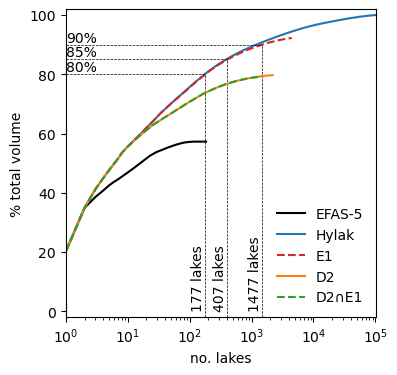

In [631]:
fig, ax = plt.subplots(figsize=(4, 4))

# EFAS5
ax.plot(np.arange(1, len(efas_acc) + 1), efas_acc, c='k', label='EFAS-5')

# HydroLakes
ax.plot(np.arange(1, len(hydrolakes_acc) + 1), hydrolakes_acc, c='C0', label='Hylak')

# E1 selection
ax.plot(np.arange(1, len(E1_acc) + 1), E1_acc, c='C3', ls='--', label='E1')
for target in [80, 85, 90]:
    n = (E1_acc - target).abs().argmin()
    ax.hlines(target, 1, n, color='k', ls='--', lw=.5)
    ax.vlines(n, -2, target, color='k', ls='--', lw=.5)
    ax.text(n, 0, f'{n} lakes', va='bottom', ha='right', rotation=90)
    ax.text(1, target, f'{target}%', va='bottom', ha='left', rotation=0)

# D2 selection
ax.plot(np.arange(1, len(D2_acc) + 1), D2_acc, c='C1', label='D2')

# intersection E1 and D2
n_lakes, pct_vol = len(E1_D2_acc), E1_D2_acc.max()
ax.plot(np.arange(1, n_lakes + 1), E1_D2_acc, c='C2', ls='--', label='D2∩E1')
# ax.hlines(pct_vol, 1, n_lakes, color='k', ls='--', lw=.5)
# ax.vlines(n_lakes, -2, pct_vol, color='k', ls='--', lw=.5)
# ax.text(n_lakes, pct_vol, f'{n_lakes} lakes', va='top', ha='right', rotation=90)
# ax.text(1, pct_vol, f'{E1_D2_acc.max():.0f}%', va='bottom', ha='left', rotation=0)

ax.set(
    xlim=(1, hydrolakes.shape[0]),
    xlabel='no. lakes',
    ylim=(-2, 102),
    ylabel='% total volume'
)
ax.set_xscale('log')
ax.legend(frameon=False, loc=4);

plt.savefig(PATH_OUT / 'percentage_total_volume.jpg', dpi=300, bbox_inches='tight')

#### Lakes to add

I will select lakes to be added in EFASv6 from the `E1` object, i.e., the selection of lakes and controlled lakes in HydroLakes that comply with the lake area, lake volume, catchment area and degree of regulation rules. From those, I will create a classification in terms of `priority`. I will sort the lakes by decreasing volume, and assign priorities depending on the percentage of total lake volume we want to reproduce in EFASv6. For instance, the lakes required to reach a 80% of the total lake volume will have priority 1, those to reach 85% priority 2, ect.

In [643]:
# create dataframe of lakes to be added
to_add_pnt = E1.copy()
to_add_pnt.sort_values('Vol_total', ascending=False, inplace=True)
to_add_acc = to_add_pnt.Vol_total.cumsum() / total_lake_volume * 100

# define priority
to_add_pnt['priority'] = -9999
priorities = {
    4: 95,
    3: 90,
    2: 85,
    1: 80,
}
for priority, target in priorities.items():
    # select lakes to reach the target
    ID = (to_add_acc - target).abs().idxmin()
    # assign priority
    to_add_pnt.loc[:ID, 'priority'] = priority

# remove lakes included in EFASv5
to_add_pnt = to_add_pnt.loc[to_add_pnt.index.difference(efas.Hylak_id)]

# remove lakes included as reservoirs in EFASv5
to_add_pnt = to_add_pnt[~to_add_pnt.Grand_id.isin(efas_res.GRAND_ID)]

# remove lakes that will be added to EFASv6 as reservoirs
to_add_pnt = to_add_pnt[~to_add_pnt.Grand_id.isin(grand_to_add.index)]

print(to_add_pnt.priority.value_counts())

3    1052
4     892
2     198
1      98
Name: priority, dtype: int64


In [644]:
# apply selection to polygons
if hydrolakes_pol.index.name != 'Hylak_id':
    hydrolakes_pol.set_index('Hylak_id', drop=True, inplace=True)
to_add_pol = hydrolakes_pol.loc[to_add_pnt.index]
to_add_pol['priority'] = -9999
to_add_pol.loc[to_add.index, 'priority'] = to_add_pnt.priority

In [645]:
# export
to_add_pnt.to_file(PATH_OUT / 'hydrolakes_pnt_to_add.shp')
to_add_pol.to_file(PATH_OUT / 'hydrolakes_pol_to_add.shp')

## Conclusion

The result of this notebook is a polygon shapefile with the 500 lakes in GLWD not already included in GloFAS with the larger surface area. The 500 lakes include 272 classified as open lakes and 228 unclassified. The addition of these lakes would increase the total lake area in GloFAS in 184·10³ km² (24% increase).

The selected lakes were checked to overlay with GloFAS rivers, being those understood as cells with an catchment area of at least 1000 km². However, visual inspection in GIS shows that some of these lakes are coastal water bodies that will probably not affect the LISFLOOD simulation. Another special case are the lakes in the Tibetan Plateau, which were selected even thouth the river network in this area is unusual.

To do a finer selection of lakes, it would be interesting to compare the list of selected lakes with GloFAS model performance to identify areas where the introduction of new lakes can improve the model simulations.